In [2]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [3]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [4]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [5]:
suffix = "_TrueVertexForSignal"

In [6]:
cut_config = "./cut_configs/preselections_BDTv1.py"

In [7]:
sig_sample_json_dir = '../'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if "skimmed_sig_v2_egamma_hadd_ntuples_2018_aEM_ctau-10." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_egamma_hadd_ntuples_2018_aEM_ctau-10']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [8]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_egamma_hadd_ntuples_2018_aEM_ctau-10


Output()

Output()

Completed in 0.79 min



In [8]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.77 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.50 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 3.66 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.25 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.24 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.65 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.18 min



## BDT

In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
h5_dir = "./h5/"
sig_suffix = "ctau-10_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

ctau = '10_'
sig_files = [f for f in os.listdir(h5_dir) if (sig_suffix in f and 'sig' in f) and (str(ctau) in f)]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# SR v3 variables
variables = ['lead_jet_pt','lead_jet_eta','minJetMETdPhi','jetMETdPhi',
             'sel_vtx_sign', 'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy']

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 4183 -> 4183 after gen matching (raw counts)

DY: 20
Diboson: 1728
QCD: 304
Top: 5528
Triboson: 210
WJets: 68705
ZJets: 98427

Number of total background events (raw counts): 174922


In [11]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

ctau = 10.
for delta in [0.1, 0.2]:
    for m1 in [5.,10.,20.,30.,40.,50.]:
        idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
        point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
        sig_subprocess[point] = idx
        print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_10.0: 132
m1_10.0_delta_0.1_ctau_10.0: 282
m1_20.0_delta_0.1_ctau_10.0: 255
m1_30.0_delta_0.1_ctau_10.0: 530
m1_40.0_delta_0.1_ctau_10.0: 611
m1_50.0_delta_0.1_ctau_10.0: 741
m1_5.0_delta_0.2_ctau_10.0: 94
m1_10.0_delta_0.2_ctau_10.0: 244
m1_20.0_delta_0.2_ctau_10.0: 416
m1_30.0_delta_0.2_ctau_10.0: 465
m1_40.0_delta_0.2_ctau_10.0: 118
m1_50.0_delta_0.2_ctau_10.0: 295
Number of signal subprocesses with non-zero count: 12


## Reweight Backgrounds

### Background raw counts

In [12]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

DY: 20
Diboson: 1728
QCD: 304
Top: 5528
Triboson: 210
WJets: 68705
ZJets: 98427


### Cutflow counts (xsec weighted)

In [13]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

DY: 2518.294876098633
Diboson: 427.0184949338436
QCD: 1970.0003677904606
Top: 624.5707487333566
Triboson: 4.918245587032288
WJets: 25299.553511117003
ZJets: 13014.62912989594
Total background counts (xsec weighted): 43858.98537415627


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [14]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [15]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

DY: 10043.670410331339
Diboson: 1703.0702001941554
QCD: 7856.917159533112
Top: 2490.964340710441
Triboson: 19.615351031664645
WJets: 100901.75528428704
ZJets: 51906.01003504695
174922.0027811347


In [16]:
nBkg

174922

In [17]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [18]:
set(bkg_xsec_norm)

{-0.05953975,
 -0.045444746,
 -0.043379143,
 -0.016287146,
 -0.012563892,
 -0.0042385785,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.2538137,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 0.59895897,
 1.1887455,
 2.7895231,
 4.6589475,
 7.842954,
 24.090977,
 37.836258,
 143.50896,
 312.20374,
 1702.3124}

In [19]:
len(bkg_sf)

174922

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [20]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 4183
Background sample size (all subprocesses summed): 174922
41.81735596461869 more background than signal samples


In [21]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 12 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [22]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 12 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 14576.833333333334


In [23]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 14576.833333333334


In [24]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess
    print(samp, sf)
    sig_sf[samp_idx] = sf

print(sig_sf)

m1_5.0_delta_0.1_ctau_10.0 110.43055555555556
m1_10.0_delta_0.1_ctau_10.0 51.69089834515367
m1_20.0_delta_0.1_ctau_10.0 57.164052287581704
m1_30.0_delta_0.1_ctau_10.0 27.503459119496856
m1_40.0_delta_0.1_ctau_10.0 23.85733769776323
m1_50.0_delta_0.1_ctau_10.0 19.671839856050383
m1_5.0_delta_0.2_ctau_10.0 155.072695035461
m1_10.0_delta_0.2_ctau_10.0 59.74112021857924
m1_20.0_delta_0.2_ctau_10.0 35.040464743589745
m1_30.0_delta_0.2_ctau_10.0 31.348028673835127
m1_40.0_delta_0.2_ctau_10.0 123.53248587570621
m1_50.0_delta_0.2_ctau_10.0 49.41299435028249
[155.07269504 155.07269504 155.07269504 ...  59.74112022  59.74112022
  59.74112022]


In [25]:
type(sig_sf)

numpy.ndarray

### Train

In [26]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [27]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [28]:
test_ctau[np.where(y_test == 1)] # signal

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [29]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [31]:
# make predictions
preds = bst.predict(test)

In [32]:
os.system('mkdir -p plots')

0

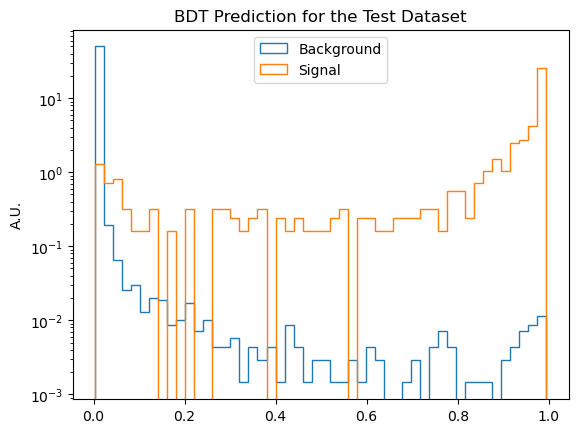

In [33]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.savefig('plots/BDTv1_ctau-10_score.png')
plt.yscale('log')

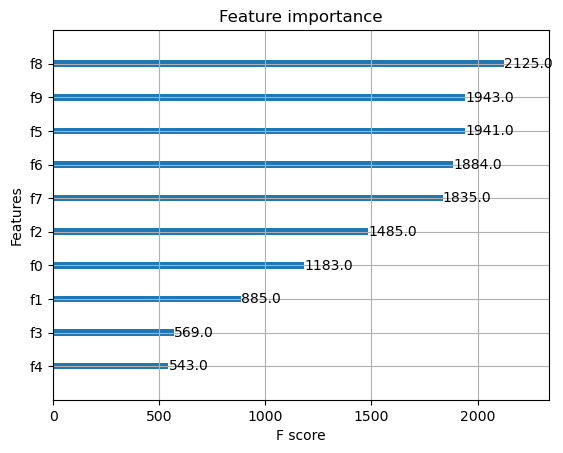

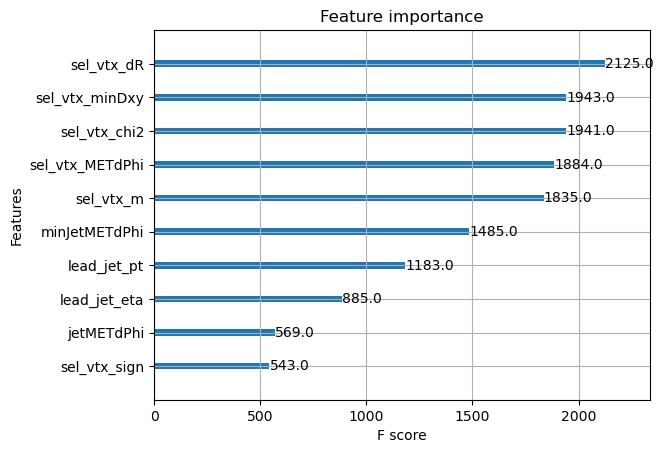

In [34]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
plt.savefig('plots/BDTv1_ctau-10_importance_bst.png', bbox_inches = "tight")

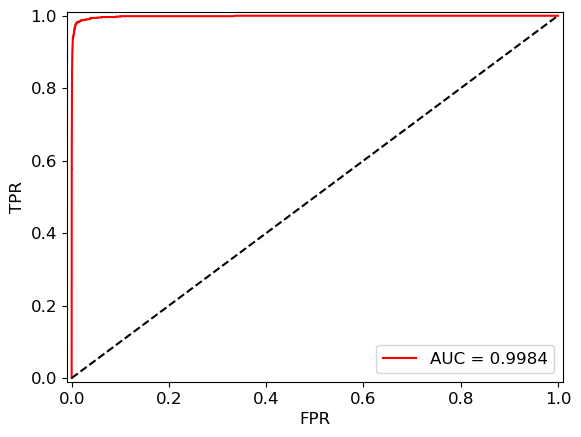

In [35]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
plt.savefig('plots/BDTv1_ctau-10_roc_curve.png')

### Save and load

In [36]:
bst.save_model('models/BDTv1_ctau-10_5to50.json')

In [37]:
trained_model = xgb.XGBRegressor()
trained_model.load_model("models/BDTv1_ctau-10_5to50.json")

In [38]:
prediction = trained_model.predict(test)

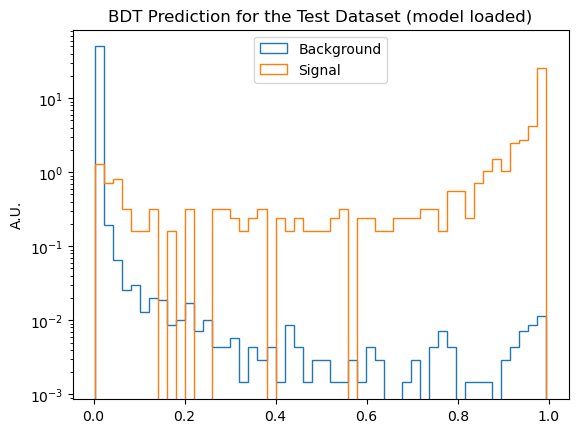

In [39]:
bins = 50

h,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset (model loaded)')

plt.ylabel('A.U.')
plt.yscale('log')

[Text(0, 0, 'sel_vtx_sign'),
 Text(0, 1, 'jetMETdPhi'),
 Text(0, 2, 'lead_jet_eta'),
 Text(0, 3, 'lead_jet_pt'),
 Text(0, 4, 'minJetMETdPhi'),
 Text(0, 5, 'sel_vtx_m'),
 Text(0, 6, 'sel_vtx_METdPhi'),
 Text(0, 7, 'sel_vtx_chi2'),
 Text(0, 8, 'sel_vtx_minDxy'),
 Text(0, 9, 'sel_vtx_dR')]

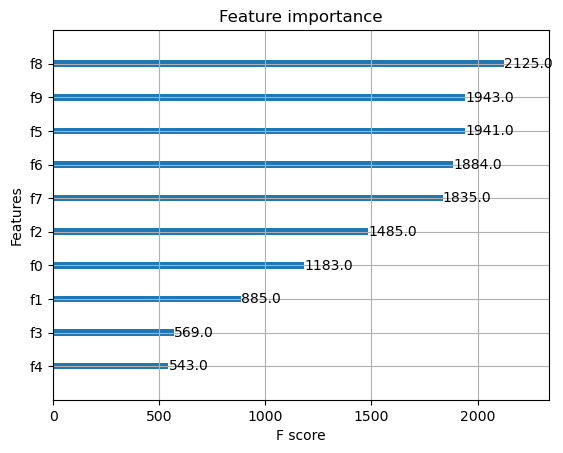

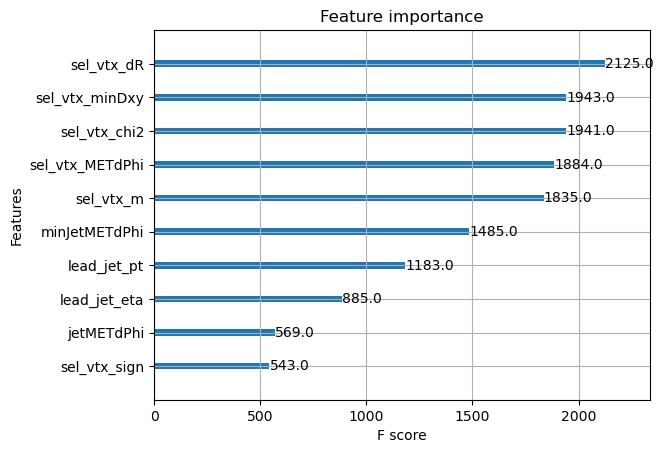

In [40]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

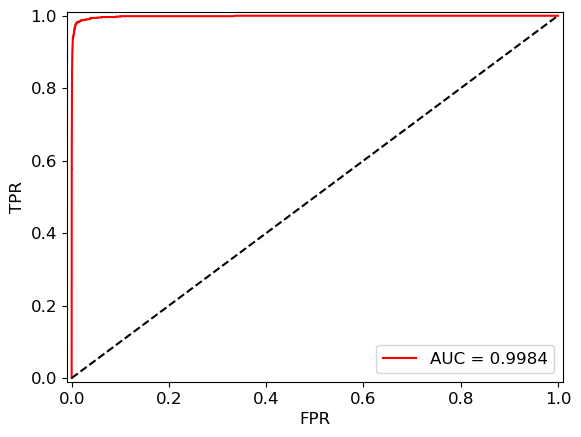

In [41]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

### WP

In [42]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [43]:
tpr_WP = {'tight': 0.7, 'medium': 0.8, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [45]:
epsilon = 0.02

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9532797336578369
medium threshold: 0.8819608092308044
loose threshold: 0.46953096985816956


### TPR

In [46]:
# BDT scores for the signal
nPass_sig = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    nPass_sig[wp] = np.sum(preds[np.where(y_test==1)] > thres_WP[wp])
    nPass_bkg[wp] = np.sum(preds[np.where(y_test==0)] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig[wp]} / {len(preds[np.where(y_test==1)])} = {nPass_sig[wp]/len(preds[np.where(y_test==1)])}')
    print(f'FPR: {nPass_bkg[wp]} / {len(preds[np.where(y_test==0)])} = {nPass_bkg[wp]/len(preds[np.where(y_test==0)])}')


tight pass
TPR: 581 / 837 = 0.6941457586618877
FPR: 14 / 34985 = 0.0004001715020723167

medium pass
TPR: 669 / 837 = 0.7992831541218638
FPR: 24 / 34985 = 0.0006860082892668287

loose pass
TPR: 755 / 837 = 0.9020310633213859
FPR: 55 / 34985 = 0.0015721023295698156


In [47]:
# for a given point
m1 = 30.
delta = 0.1
ctau = 10.

nPass_sig_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
nPass_bkg_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}

for wp in nPass_sig.keys():
    sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
    bkg_idx = np.where(y_test==0)
    
    nPass_sig_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
    nPass_bkg_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])
    
    print(f'\n{wp} pass')
    print(f'TPR: {nPass_sig_sigpoint[wp]} / {len(preds[sig_idx])} = {nPass_sig_sigpoint[wp]/len(preds[sig_idx])}')
    print(f'FPR: {nPass_bkg_sigpoint[wp]} / {len(preds[bkg_idx])} = {nPass_bkg_sigpoint[wp]/len(preds[bkg_idx])}')


tight pass
TPR: 73 / 103 = 0.7087378640776699
FPR: 14 / 34985 = 0.0004001715020723167

medium pass
TPR: 87 / 103 = 0.8446601941747572
FPR: 24 / 34985 = 0.0006860082892668287

loose pass
TPR: 99 / 103 = 0.9611650485436893
FPR: 55 / 34985 = 0.0015721023295698156


### TPR per signal point

In [48]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [10.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 13 / 27 = 0.48148148148148145
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 17 / 27 = 0.6296296296296297
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 25 / 27 = 0.9259259259259259
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 37 / 68 = 0.5441176470588235
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 50 / 68 = 0.7352941176470589
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 63 / 68 = 0.9264705882352942
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 30 / 47 = 0.6382978723404256
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 37 / 47 = 0.7872340425531915
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 43 / 47 = 0.9148936170212766
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 73 / 103 = 0.7087378640776699
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 87 / 103 = 0.8446601941747572
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 99 / 103 = 0.9611650485436893
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 90 / 115 = 0.782608695652174
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 95 / 115 = 0.8260869565217391
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 106 / 1

In [49]:
tpr_raw

{'0.1': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [0.48148148148148145,
    0.5441176470588235,
    0.6382978723404256,
    0.7087378640776699,
    0.782608695652174,
    0.6474358974358975],
   'medium': [0.6296296296296297,
    0.7352941176470589,
    0.7872340425531915,
    0.8446601941747572,
    0.8260869565217391,
    0.75],
   'loose': [0.9259259259259259,
    0.9264705882352942,
    0.9148936170212766,
    0.9611650485436893,
    0.9217391304347826,
    0.8653846153846154]},
  'ct-100': {'tight': [], 'medium': [], 'loose': []}},
 '0.2': {'ct-1': {'tight': [], 'medium': [], 'loose': []},
  'ct-10': {'tight': [0.6666666666666666,
    0.8421052631578947,
    0.7575757575757576,
    0.8241758241758241,
    0.5384615384615384,
    0.6031746031746031],
   'medium': [0.7777777777777778,
    0.9473684210526315,
    0.8787878787878788,
    0.8901098901098901,
    0.6153846153846154,
    0.6825396825396826],
   'loose': [0.9444444444444444,
    0.98245614035

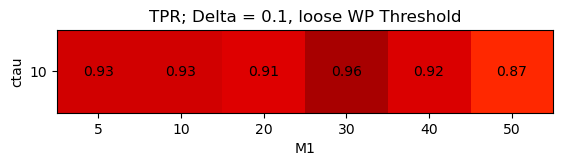

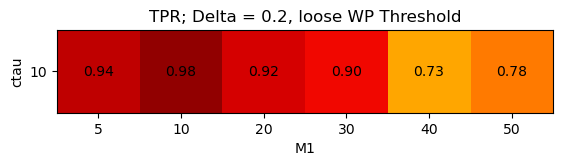

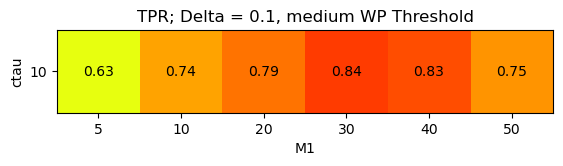

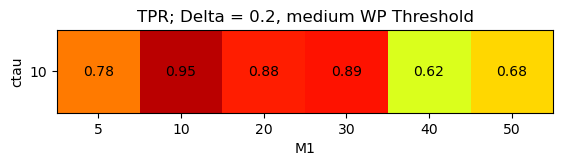

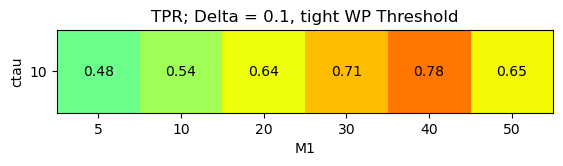

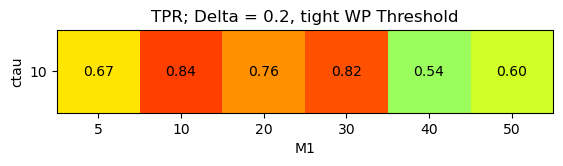

In [50]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [10])
        plt.gca().invert_yaxis()
        
        plt.show()

### TPR on half dataset (not just 20%)

In [51]:
train_size = 0.5

sig_train, sig_test = train_test_split(sig_data,train_size=train_size,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=train_size, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=train_size, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=train_size, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=train_size, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=train_size, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=train_size,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=train_size, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=train_size, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=train_size, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

#perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

#perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [52]:
preds = bst.predict(test)

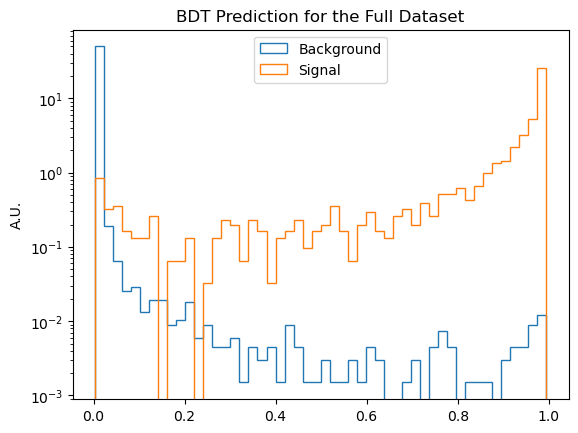

In [53]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Full Dataset')

plt.ylabel('A.U.')
#plt.savefig('plots/BDTscore.png')
plt.yscale('log')

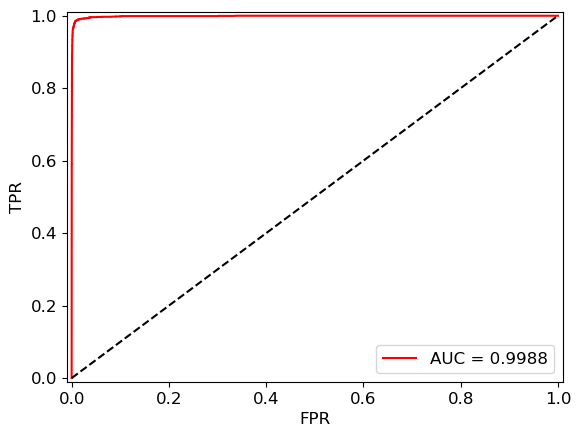

In [54]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

In [55]:
tpr_raw = { '0.1': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}, \
            '0.2': {'ct-1': {'tight':[], 'medium':[], 'loose':[]}, 'ct-10': {'tight':[], 'medium':[], 'loose':[]}, 'ct-100': {'tight':[], 'medium':[], 'loose':[]}}
          }

for ctau in [10.]:
    for delta in [0.1, 0.2]:
        for m1 in [5., 10., 20., 30., 40., 50.]:
            nPass_sig_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            nPass_bkg_raw_sigpoint = {'tight': 0, 'medium': 0, 'loose': 0}
            
            for wp in nPass_sig.keys():
                sig_idx = np.where(((y_test==1) & (test_m1 == m1)) & ((test_delta == delta) & (test_ctau == ctau)))
                bkg_idx = np.where(y_test==0)
                
                nPass_sig_raw_sigpoint[wp] = np.sum(preds[sig_idx] > thres_WP[wp])
                nPass_bkg_raw_sigpoint[wp] = np.sum(preds[bkg_idx] > thres_WP[wp])

                if len(sig_idx[0]) == 0:
                    tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(0)
                    continue
                
                print(f'm1 = {m1}, delta = {delta}, ct = {ctau}')
                print(f'TPR: {nPass_sig_raw_sigpoint[wp]} / {len(sig_idx[0])} = {nPass_sig_raw_sigpoint[wp]/len(sig_idx[0])}')

                tpr_raw[f'{delta}'][f'ct-{int(ctau)}'][wp].append(nPass_sig_raw_sigpoint[wp]/len(sig_idx[0]))

m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 31 / 64 = 0.484375
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 45 / 64 = 0.703125
m1 = 5.0, delta = 0.1, ct = 10.0
TPR: 60 / 64 = 0.9375
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 90 / 149 = 0.6040268456375839
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 112 / 149 = 0.7516778523489933
m1 = 10.0, delta = 0.1, ct = 10.0
TPR: 141 / 149 = 0.9463087248322147
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 105 / 141 = 0.7446808510638298
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 122 / 141 = 0.8652482269503546
m1 = 20.0, delta = 0.1, ct = 10.0
TPR: 135 / 141 = 0.9574468085106383
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 202 / 265 = 0.7622641509433963
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 230 / 265 = 0.8679245283018868
m1 = 30.0, delta = 0.1, ct = 10.0
TPR: 258 / 265 = 0.9735849056603774
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 231 / 314 = 0.7356687898089171
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 261 / 314 = 0.8312101910828026
m1 = 40.0, delta = 0.1, ct = 10.0
TPR: 298 / 314 = 0.949044585

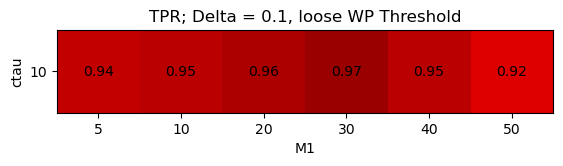

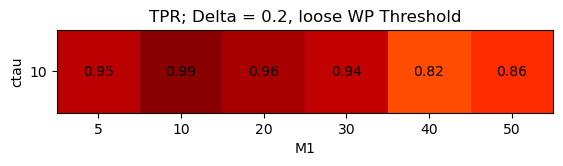

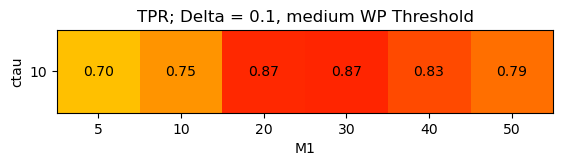

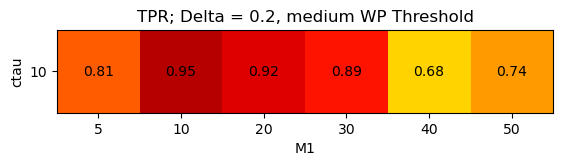

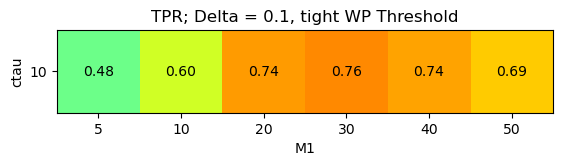

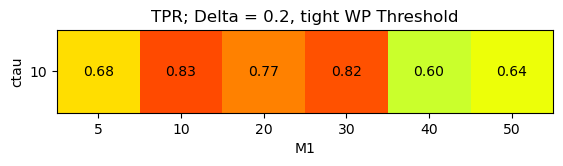

In [56]:
for wp in ['loose', 'medium', 'tight']:
    for delta in ['0.1', '0.2']:
        fig, ax = plt.subplots(1)
      
        arr = np.array([tpr_raw[delta]['ct-10'][wp]])
        
        ax.imshow(arr, interpolation ='none', cmap='jet', vmin=0, vmax=1)
        
        #plt.colorbar(im)
        
        for (j,i),label in np.ndenumerate(arr):
            label = '{:.2f}'.format(label)
            ax.text(i,j,label,ha='center',va='center')
        
        plt.title(f'TPR; Delta = {delta}, {wp} WP Threshold')
        plt.ylabel('ctau')
        plt.xlabel('M1')
        
        plt.xticks(range(0,6), [5, 10, 20, 30, 40, 50])
        plt.yticks(range(0,1), [10])
        plt.gca().invert_yaxis()
        
        plt.show()

### Pearson Correlation Coefficient

In [57]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [58]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

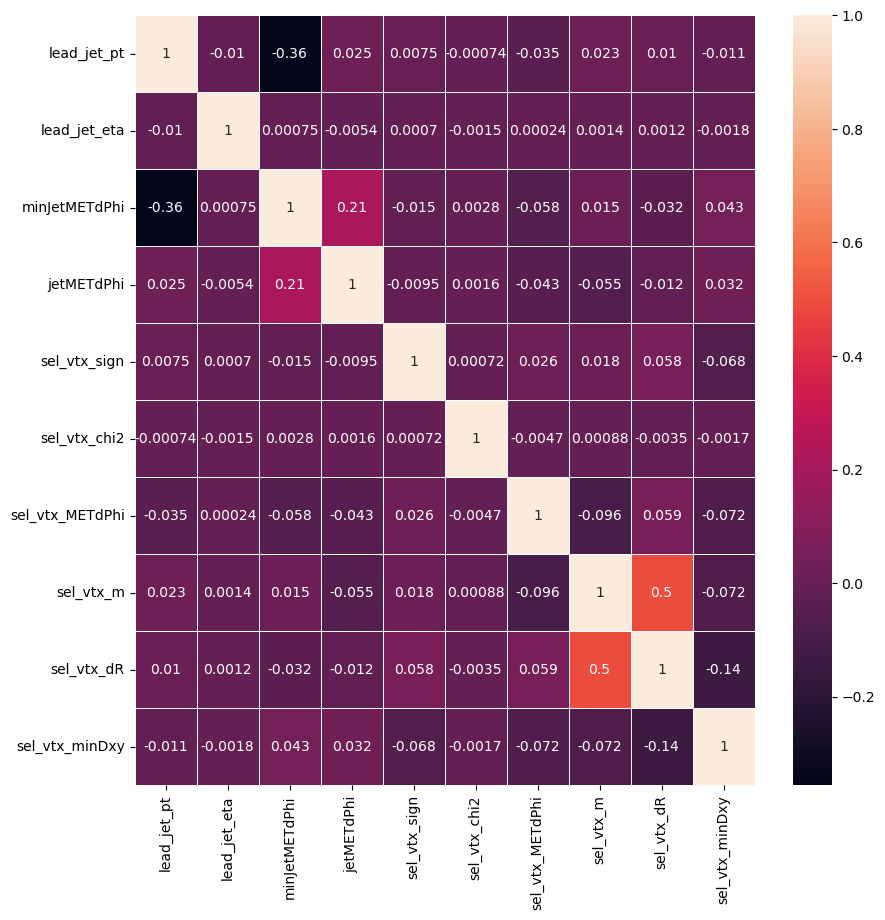

In [59]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 174922)')

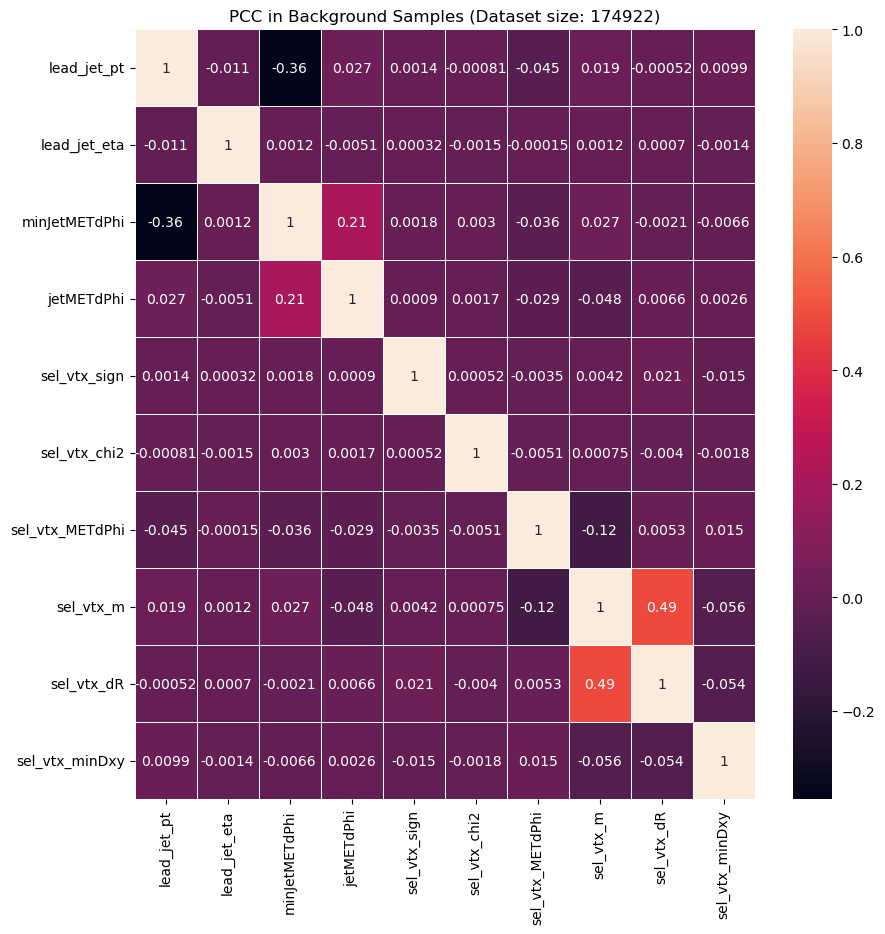

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 4183)')

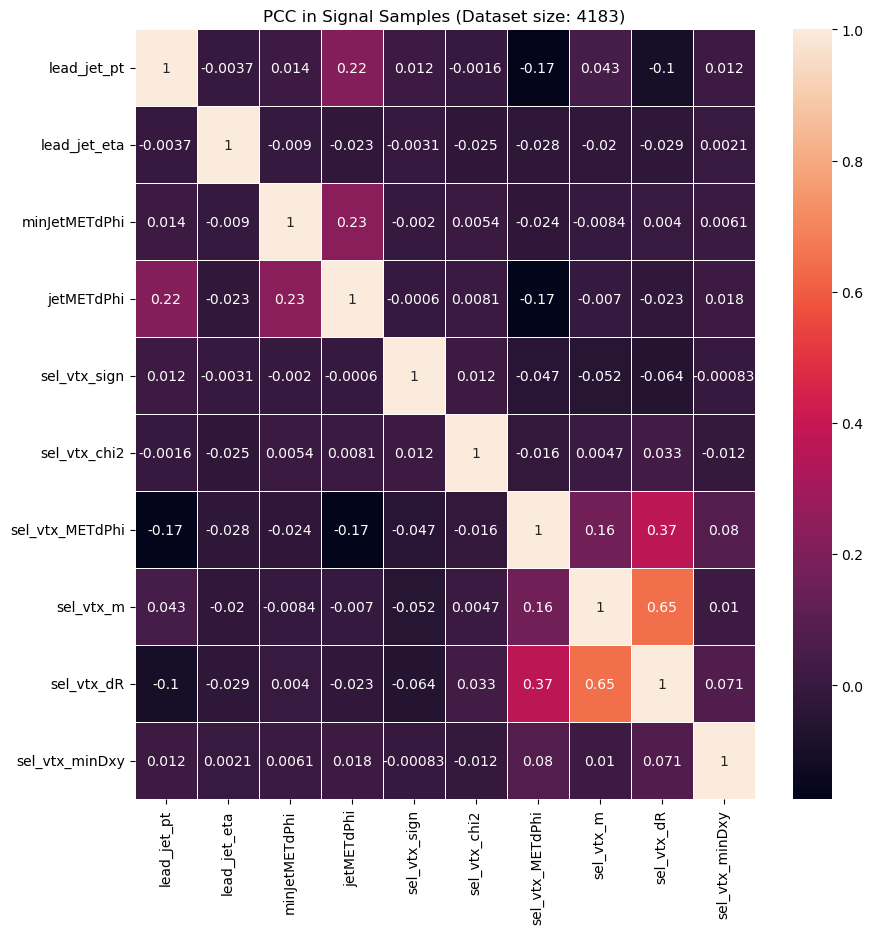

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')